# Web Scraping

In [ ]:
!pip install selenium
!apt-get -q update   #Used to handle installation and removal of softwares and libraries
!apt install -yq chromium-chromedriver #ChromeDriver is a separate executable that Selenium WebDriver uses to control Chrome.
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

import sys
sys.path.insert(0,'chromedriver')

from selenium import webdriver
from selenium.webdriver.common.by import By

#WebDriver is a browser automation framework that works with open source APIs.
#The framework operates by accepting commands, sending those commands to a browser, and interacting with applications.
chrome_options = webdriver.ChromeOptions()
#headless means running chrome with chrome.exe
chrome_options.add_argument('--headless')

chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

In [ ]:
import pandas as pd

comments = pd.DataFrame(columns = ['Date','user_id','comments'])

for i in range(106):
    x = 330 + i
    url_to_go = 'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p'+str(x)
    print(i, url_to_go)
    
    driver = webdriver.Chrome(options=chrome_options)
    driver.get(url_to_go)
    elements = driver.find_elements(By.CLASS_NAME, "Comment")

    for element in elements:
      author = element.find_element(By.CLASS_NAME, "Author").text
      #print(element.find_element(By.CLASS_NAME, "Meta CommentMeta CommentInfo").text)
      date = element.find_element(By.TAG_NAME, "time").text
      comment = element.find_element(By.CLASS_NAME, "Item-Body").text
    
      #/** loc=locator
      comments.loc[len(comments.index)] = [author, date, comment]
    

In [ ]:
len(comments)

#### We have scraped **5284** posts from the forum

### Implementation

In [ ]:
!pip install nltk

In [4]:
import csv
import re
import string
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import combinations
from itertools import product
import os
import warnings

# Suppress warnings
warnings.filterwarnings('ignore') 


## Defining the constant variables.

**unique_brands_list** :  List of all unique brands available in the car_model_brand.csv file.

**top_attributes_list** : List of top 6 attributes that appeared the most in our scraped data. 

**aspiration_list** : Bigrams/Unigrams that we found in our scraped data.

In [6]:
input_filename = os.path.join('Input Files', 'check_data.csv')  # Input file
word_freq_output = os.path.join('Output Files', 'Word_Frequency.csv')  # Output file for word frequencies
word_freq_rank_input = os.path.join('Input Files', 'Word_Frequency_Rank.csv') 
brand_pair_output = os.path.join('Output Files', 'brand_pair.csv') #Output file for top most occurring word pairs
attributes_pair_output = os.path.join('Output Files', 'attributes_pair.csv') #Output file for top 5 brands and top 6 attributes
aspiration_pair_output = os.path.join('Output Files', 'aspiration_pair.csv') #Output file for top 5 brands and aspiration

car_models_brands_file = os.path.join('Input Files', 'car_models_and_brands.csv') #Brand and Model names

top_brands_lift_values = os.path.join('Output Files', 'Top_Brands_Lift_Values.csv')  # Output file for lift values
top_brands_lift_matrix = os.path.join('Output Files', 'Top_Brands_Lift_Matrix.csv')  # Output file for lift matrix

attributes_lift_matrix = os.path.join('Output Files', 'Attributes_Lift_Matrix.csv') 

aspirations_lift_matrix = os.path.join('Output Files', 'Aspiration_Lift_Matrix.csv') 

#Let's define based on scraped data
unique_brands_list = ['acura', 'audi', 'bmw', 'buick', 'cadillac', 'chevrolet', 'chrysler', 'dodge', 'ford', 'honda','hyundai',\
                      'infiniti', 'kia', 'lincoln', 'mazda', 'mercedes', 'mercury', 'mitsubishi', 'nissan', 'pontiac', 'problem', \
                      'saturn', 'subaru', 'suzuki', 'toyata', 'toyota', 'volkswagen', 'volkwagen', 'volvo', 'lexus']

#Let's define based on attributes observed from word frequency
top_attributes_list = ['performance', 'engine', 'price', 'luxury', 'tech', 'comfortable']

#Aspirational Words
aspiration_list = ['wish to', 'desire to', 'aspire', 'looking forward', 'plan to', 'like to', 'think of', 'want to'\
                   , 'dream of', 'hope to', 'intend to', 'buy', 'purchase']

## Task B.

### Script for replacing the models with brands.
The script is loading the words in the dictionary, which is then later being called for replacement of models with brands. 

In [8]:
def load_replacement_pairs():
    replacement_csv = car_models_brands_file
    replacement_dict = {}
    with open(car_models_brands_file, 'r', newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)
        for row in reader:
            if len(row) == 2:
                original_word, replacement_word = row
                replacement_dict[replacement_word.lower()] = original_word.lower()
    
    return replacement_dict

replacement_dict = load_replacement_pairs()

### Calculate Individual Words Frequency

1. The STOP WORDS haven't been removed.

2. Once the word frequencies are fetched, it is being sorted in descending order and written to to **'Word_Frequency.csv'** file.

3. Top 10 brands are being printed as well for quick reference.

In [10]:
sentences_clean = []
tokenized_posts = []

with open(input_filename, 'r', newline='', encoding='utf-8') as infile:
    reader = csv.reader(infile)
    next(reader)
    for row in reader:
        # Extract text from the third column (index 2)
        text = row[3]

        #Remove punctuations from the texts and convert it to lower case
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text.lower()) 
        
        #Tokenize words
        words = word_tokenize(text)
        
        #Replace models with brands
        words = [replacement_dict.get(word, word) for word in words]

        tokenized_posts.append(tuple(words))
        
        #Append individual words to the list
        sentences_clean.extend(words)
        
#Calculate individual word frequency
word_frequency = Counter(sentences_clean)

#Sort the word frequency list based on descending order
sorted_word_frequency = sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)

#Write the word frequency to the CSV file
with open(word_freq_output, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['Word', 'Frequency'])
        for word, freq in sorted_word_frequency:
            writer.writerow([word, freq])

## Top 10 Brands

In [355]:
top_10_brands = pd.DataFrame([(brand, freq) for brand, freq in sorted_word_frequency if brand in unique_brands_list][:10], columns=['Top_10_Brands', 'Frequency'])
display(top_10_brands)

,Top_10_Brands,Frequency
0,bmw,3459
1,audi,3292
2,acura,2611
3,honda,2409
4,subaru,1307
5,volkswagen,1143
6,toyota,988
7,hyundai,549
8,cadillac,539
9,infiniti,470


## Task A.
### Finding the Value of Beta (Coefficient)

                                 OLS Regression Results                                
Dep. Variable:               LogRatio   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.968e+07
Date:                Thu, 19 Sep 2024   Prob (F-statistic):                        0.00
Time:                        19:18:26   Log-Likelihood:                         -7420.0
No. Observations:               21536   AIC:                                  1.484e+04
Df Residuals:                   21535   BIC:                                  1.485e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

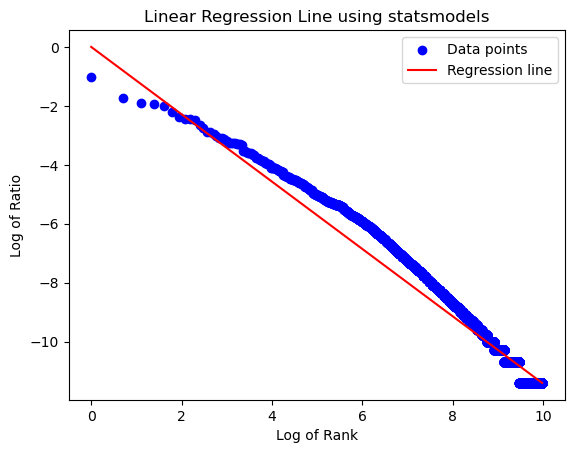

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import t

# Load the dataset
word_freq_df = pd.read_csv(word_freq_rank_input)
n = word_freq_df[:100]
frequency_max_words = word_freq_df.iloc[99][1]
# Extract rank and frequency columns
#ranks = word_freq_df['Rank']
word_freq_df['LogRank'] = np.log(word_freq_df['Rank'])
word_freq_df['LogRatio'] = np.log(word_freq_df['Frequency']/ (100 * frequency_max_words))

# Assume you have a pandas DataFrame `df` with features and target
# Replace 'features' and 'target' with actual column names
X = word_freq_df[['LogRank']]# Features (independent variables)
# X = sm.add_constant(X)
y = word_freq_df['LogRatio']  # Target (dependent variable, e.g., housing prices)

# Perform linear regression using statsmodels
model = sm.OLS(y, X)
results = model.fit()

# Print the summary of the regression
print(results.summary())
# Hypothesis Testing for beta = -1
# Extract the estimated beta (slope) and its standard error
estimated_beta = results.params[0]  # Slope for log(frequency)
standard_error_beta = results.bse[0]

# Hypothesized beta value
hypothesized_beta = -1

# Print the hypothesis test results
print(f"\nHypothesis Testing for beta = -1")
print(f"\n\033[1;94mStandard error of beta: {standard_error_beta}\033[0m")

# Calculate the confidence interval for beta
confidence_level = 0.95
alpha = 1 - confidence_level

t_critical = t.ppf(1 - alpha/2, results.df_resid)
print(f"\n\033[1;94mt_critical : {t_critical}\033[0m")
# Calculate the confidence interval
ci_lower = estimated_beta - t_critical * standard_error_beta
ci_upper = estimated_beta + t_critical * standard_error_beta

print(f"\n\033[1;94mEstimated beta: {estimated_beta}\033[0m")
print(f"\n\033[1;94m95% Confidence Interval for beta: [{ci_lower}, {ci_upper}]\033[0m")

conf_interval = results.conf_int(alpha=0.05)  # 95% confidence intervals (alpha=0.05 means 95%)
# Plot the data and the regression line

y_pred = results.predict(X)

# Plot the data points
plt.scatter(word_freq_df['LogRank'], y, color='blue', label='Data points')

# Plot the regression line
plt.plot(word_freq_df['LogRank'], y_pred, color='red', label='Regression line')

# Add labels and title
plt.xlabel('Log of Rank')
plt.ylabel('Log of Ratio')
plt.title('Linear Regression Line using statsmodels')

# Display legend
plt.legend()

# Show the plot
plt.show()


### Findings

#### 1. Test if the data support Zipf’s law econometrically

**Beta-value : -1.1428401053615747**

From the linear regression, we can see that the slope of the data falls in the range of ***[-1.428799673714056, -1.4237586672009799]***, that means, the ideal slope of -1 is outside 95% confidence interval. ***This means Zipf's law doesn't hold for the data.***

#### 2. Plotting the Zipf Law Curve with most common 100 words (without removing stop words)

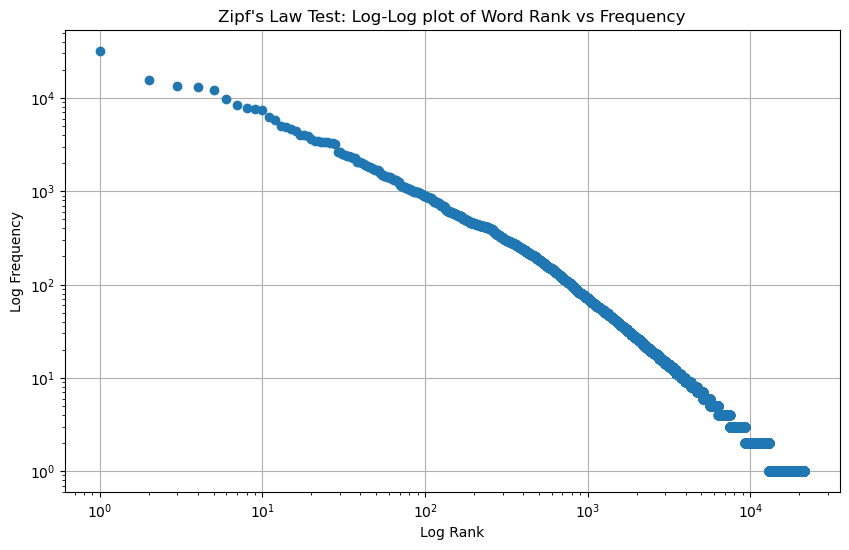

100


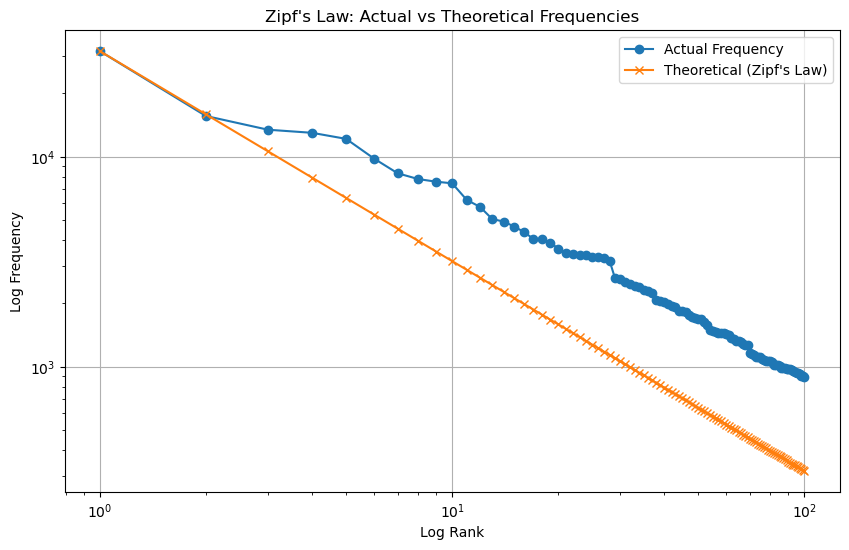

In [17]:
def plot_zipf_law_curve(sorted_word_frequency):
    ranks = np.arange(1, len(sorted_word_frequency) + 1)
    frequencies = [freq for word, freq in sorted_word_frequency]
    
    # Plot Zipf's law on a log-log scale
    plt.figure(figsize=(10, 6))
    plt.loglog(ranks, frequencies, marker="o", linestyle="none")
    plt.title("Zipf's Law Test: Log-Log plot of Word Rank vs Frequency")
    plt.xlabel("Log Rank")
    plt.ylabel("Log Frequency")
    plt.grid(True)
    plt.show()

def plot_zipf_law_comparision(sorted_word_frequency):
    # Extract the top `num_words` most common words
    num_words = 100
    print(num_words)
    most_common_words = sorted_word_frequency[:100]
    
    # Ranks for the top `num_words`
    ranks = np.arange(1, num_words + 1)
    
    # Actual frequencies of the top `num_words`
    actual_frequencies = [freq for word, freq in most_common_words]
    
    # Predicted frequencies based on Zipf's law
    predicted_frequencies = [actual_frequencies[0] / rank for rank in ranks]
    
    # Plot the actual frequencies and theoretical Zipf’s law predictions
    plt.figure(figsize=(10, 6))
    plt.plot(ranks, actual_frequencies, marker='o', label="Actual Frequency")
    plt.plot(ranks, predicted_frequencies, marker='x', label="Theoretical (Zipf's Law)")
    
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f"Zipf's Law: Actual vs Theoretical Frequencies")
    plt.xlabel('Log Rank')
    plt.ylabel('Log Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_zipf_law_curve(sorted_word_frequency)
plot_zipf_law_comparision(sorted_word_frequency)

### Defining function for creating following word pairs for lift calculation
**Top 10 Brands | Top 5 Brands - Top 6 Attributes | Top 10 Brands-Aspiration**

In [149]:
brand_pairs = []
attributes_pair = []
aspiration_pair = []

def generate_word_pairs(df_word_freq):
   
    # Filter word frequencies to include only brands
    df_word_freq = df_word_freq[df_word_freq['Word'].isin(unique_brands_list)]
   
    # Sort words by frequency in descending order
    df_word_freq = df_word_freq.sort_values(by='Frequency', ascending=False)
    
    # Get the top N brands
    top_10_brands = df_word_freq.head(10)['Word'].tolist()
    top_5_brands = df_word_freq.head(5)['Word'].tolist()   
    
    # Generate all possible pairs of the top N brands including the additional brand
    brand_pairs = list(combinations(top_10_brands, 2))
    attributes_pair = list(product(top_5_brands, top_attributes_list))
    aspiration_pair = list(product(top_10_brands, ['Aspiration']))

    # Write pairs to the output file
    with open(brand_pair_output, 'w') as f:
        f.write("Brand1,Brand2\n")
        for brand1, brand2 in brand_pairs:
            f.write(f"{brand1},{brand2}\n")
    
    with open(attributes_pair_output, 'w') as f:
        f.write("Brand1,Attributes\n")
        for brand, attribute in attributes_pair:
            f.write(f"{brand},{attribute}\n")

    with open(aspiration_pair_output, 'w') as f:
        f.write("Brand1,Bigram\n")
        for brand, aspiration in aspiration_pair:
            f.write(f"{brand},{aspiration}\n")


    return brand_pairs, attributes_pair, aspiration_pair

# Run the function to generate the brand pairs
df_word_freq = pd.read_csv(word_freq_output)
generate_word_pairs(df_word_freq)

## Task C
#### Lift Calculation

The following piece of code generates the word pairs between **Top 10 brands** & **Top 5 brands with attributes and the word 'Aspiration'**

In [21]:
# Step 1: Load the words from the edmunds_pair_keys.txt file and generate all pairs
def load_word_pairs():
    """
    Loads words from a file where words are comma-separated in each row.
    Returns a list of all possible word pairs for each row.
    """
    brands_pairs = []
    with open(brand_pair_output, 'r') as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            words = [word.strip() for word in row if word.strip()]
            pairs = list(combinations(words, 2))
            brands_pairs.extend(pairs)

    attributes_pair = []
    with open(attributes_pair_output, 'r') as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            words = [word.strip() for word in row if word.strip()]
            pairs = list(combinations(words, 2))
            attributes_pair.extend(pairs)

    aspiration_pair = []
    with open(aspiration_pair_output, 'r') as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            words = [word.strip() for word in row if word.strip()]
            pairs = list(combinations(words, 2))
            aspiration_pair.extend(pairs)
    
    return brands_pairs, attributes_pair, aspiration_pair
brands_pair, attributes_pair, aspiration_pair = load_word_pairs()

**The following piece of code calculate the lift value.**

In [157]:
# Total number of sets in unique_tokens
total_sets = len(tokenized_posts)

# Function to calculate probability of a word appearing in the sets
def get_word_count(word, tokenized_posts):
    count = sum(1 for token_set in tokenized_posts if word in token_set)
    return count / total_sets

# Function to calculate probability of both words in a pair appearing together in the sets
def prob_pair(word1, word2, word_distance, tokenized_posts):
    count = 0
    for token_set in tokenized_posts:
        positions_word1 = [i for i, word in enumerate(token_set) if word == word1]
        positions_word2 = [i for i, word in enumerate(token_set) if word == word2]
        
        found_valid_pair = False
        for pos1 in positions_word1:
            for pos2 in positions_word2:
                if abs(pos1 - pos2) <= word_distance:
                    found_valid_pair = True
                    break
            if found_valid_pair:
                break
        if found_valid_pair:
            count += 1
    return count / total_sets if total_sets > 0 else 0 (edited)

**The following piece of code saves the lift matrices as a CSV file.**

In [167]:
def save_results(df_lift,lift_matrix_file):
    """
    Writes the calculated lift values to a CSV file and also generates a lift matrix,
    saving it to another CSV.
    """
    # Generate lift matrix
    unique_words = list(set(df_lift['Brand1']).union(set(df_lift['Brand2'])))
    lift_matrix = pd.DataFrame(index=unique_words, columns=unique_words).fillna(0)
    
    for _, row in df_lift.iterrows():
        word1, word2, lift_value = row
        lift_matrix.at[word1, word2] = lift_value
        lift_matrix.at[word2, word1] = lift_value  # Since lift is symmetric

    for i in range(len(unique_words)):
        lift_matrix.iloc[i, i] = ''  # Set diagonal to NaN
        for j in range(i):
            lift_matrix.iloc[i, j] = ''
    
    # Save lift matrix
    lift_matrix.to_csv(lift_matrix_file)
    return lift_matrix

 **Lift calculation between Top 10 Brands pairs**

In [257]:
top_brands_lift = []
for word1, word2 in brands_pair:
    p_word1 = get_word_count(word1, tokenized_posts)
    p_word2 = get_word_count(word2, tokenized_posts)
    p_word1_word2 = prob_pair(word1, word2, 5000, tokenized_posts)
    
    if p_word1 * p_word2 > 0:  # Avoid division by zero
        lift = p_word1_word2 / (p_word1 * p_word2)
    else:
        lift = 0
   
    top_brands_lift.append({'Brand1': word1, 'Brand2': word2, 'lift_value': round(lift,3)})

df_lift = pd.DataFrame(top_brands_lift)
df_lift.to_csv(top_brands_lift_values, index=False)

### Top 10 Brands - Lift Matrix

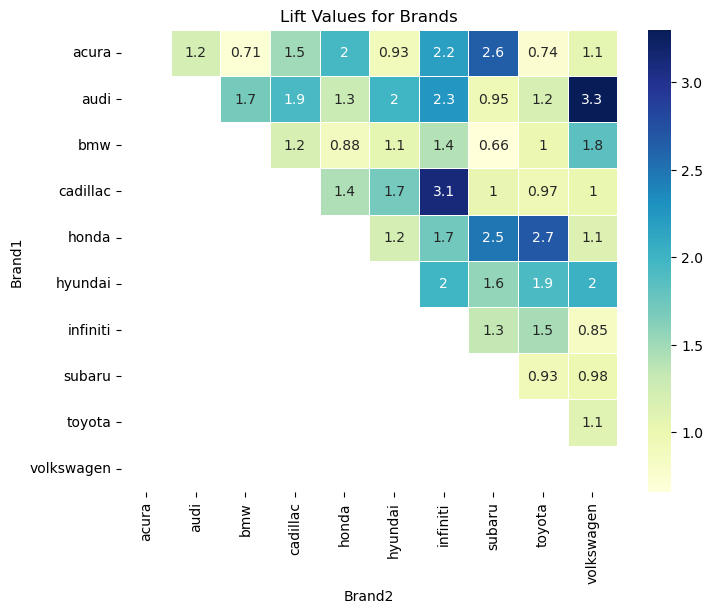

In [282]:
df_swapped = df_lift[['Brand2', 'Brand1', 'lift_value']].copy()
df_swapped.columns = ['Brand1', 'Brand2', 'lift_value']
lift_data = pd.concat([df_lift, df_swapped], ignore_index=True)

# Create the pivot table (lift matrix)
top_brands_lift_matrix = lift_data.pivot(index='Brand1', columns='Brand2', values='lift_value')
# Mask the lower half by creating a boolean mask
mask = np.tril(np.ones_like(top_brands_lift_matrix, dtype=bool))

# Plot the heatmap with the mask applied to hide the lower triangle
plt.figure(figsize=(8, 6))
sns.heatmap(top_brands_lift_matrix, annot=True, cmap="YlGnBu", cbar=True, linewidths=.5, mask=mask)

# Set labels and title
plt.title("Lift Values for Brands")
plt.show()


## Task D
#### MDS Plot

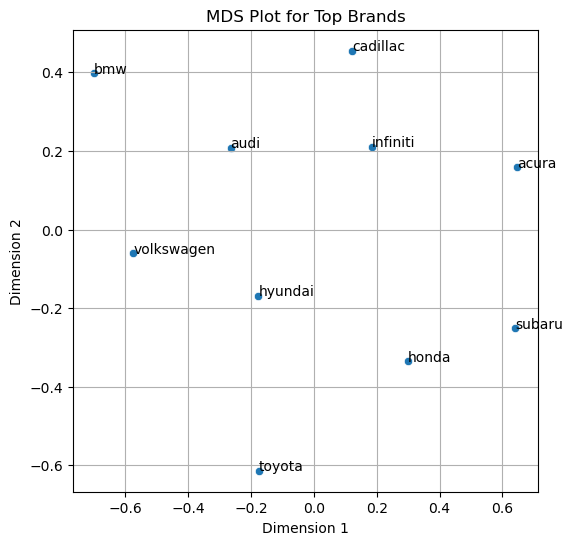

In [312]:
from sklearn.manifold import MDS
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

#Calculating dissimaliry : 1/lift
lift_data['distance'] = 1 / lift_data['lift_value']

distance_matrix = lift_data.pivot(index='Brand1', columns='Brand2', values='distance')

# Fill missing values with large numbers (since missing distances could be considered as infinite)
distance_matrix = distance_matrix.fillna(0)

# Perform MDS
mds = MDS(random_state=42, dissimilarity='precomputed')

# Symmetrizing the distance matrix
sym_distance_matrix = distance_matrix.copy()
sym_distance_matrix = np.maximum(sym_distance_matrix, sym_distance_matrix.T)
sym_distance_matrix = sym_distance_matrix.fillna(0)

# Perform MDS on the symmetrized distance matrix
mds_fit = mds.fit_transform(sym_distance_matrix)

# Create a scatter plot for the MDS result
plt.figure(figsize=(6,6))
sns.scatterplot(x=mds_fit[:, 0], y=mds_fit[:, 1])

# Add labels to the scatter plot
for i, word in enumerate(sym_distance_matrix.index):
    plt.text(mds_fit[i, 0], mds_fit[i, 1], word)
    
plt.title('MDS Plot for Top Brands')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()


## Task E
#### Analysis of MDS plot / Lift Values

*While our MDS plot is not able to capture clear details on what we expected, and what we analysed, we have tried to list our findings/analysis based on the correlation or co-mentioned we found through lift values.*

1. There are high comentions of Acura with Subaru, which is not as per expectation given Subaru is not a luxury brand.
2. Volkswagen and Audi have high lift value. Although the brands have same parent company, but Audi is the luxury brand where is Volkswagon is mid segment brand with much cheaper option.
3. Infiniti is positioned equidistantly between Audi and Acura, reflecting its target market of upper middle class consumers. Audi appeals to the upper class, while Acura targets the middle class.
4. Similarly Infinity and Hyundai have very high co-mentions taking the lift grater than 1.7
5. Cadillac and Audi have high comentions (based on lift value table) which is surprising given the target market / persona for the brands and products they sell

## Task F
 **Lift calculation between different Brands - Attributes pairs**

In [353]:
top_6_attributes = pd.DataFrame([(brand, freq) for brand, freq in sorted_word_frequency if brand in top_attributes_list][:6], columns=['Top_6_Attributes', 'Frequency'])
display(top_6_attributes)

,Top_6_Attributes,Frequency
0,price,1065
1,luxury,939
2,tech,889
3,performance,600
4,engine,549
5,comfortable,87


In [327]:
import seaborn as sns 
import matplotlib.pyplot as plt

attributes_lifts = {}
attribute_values = []
for word1, word2 in attributes_pair:
    p_word1 = get_word_count(word1, tokenized_posts)
    p_word2 = get_word_count(word2, tokenized_posts)
    p_word1_word2 = prob_pair(word1, word2, 50, tokenized_posts)
    
    if p_word1 * p_word2 > 0:  # Avoid division by zero
        attributes_lifts = p_word1_word2 / (p_word1 * p_word2)
    else:
        attributes_lifts = 0
   
    attribute_values.append({'Brands': word1, 'Attributes': word2, 'lift_value': round(attributes_lifts,3)})

df = pd.DataFrame(attribute_values)
# Step 3: Pivot the DataFrame
brand_attribute_matrix = df.pivot(index='Attributes', columns='Brands', values='lift_value')

### Brand-Attribute Lift Values

The lift values for Brands and Attributes have been calculated above and being displayed in a form of heatmap.

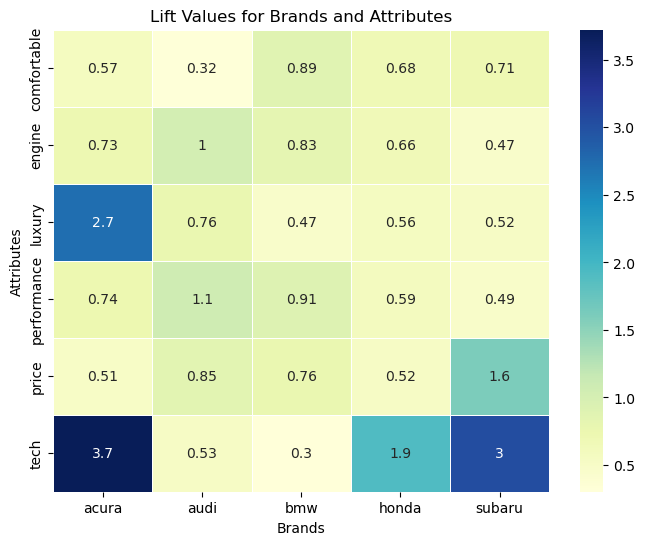

In [329]:
plt.figure(figsize=(8, 6))
sns.heatmap(brand_attribute_matrix, annot=True, cmap="YlGnBu", cbar=True, linewidths=.5)
# Set labels and title
plt.title("Lift Values for Brands and Attributes")
plt.show()

## Task G
#### Analysis of Attribute with the Brands:
1. Seems like compared to Luxury brands like Audi and BMW, mid level brands like Honda, Subaru are beating them in tech features
2. While the tagline of BMW is "Ultimate Driving Machine", it has lift values lower than 1 with "Performance", which reflects that entry level luxury cars of BMW are not resonating with brand image

## Task H
### Brand-Aspiration Lift Values

**Approach:** 

To calculate the lift value for Aspirational Brands, we first identified a few Unigrams or Bigrams - that represents aspirations in our posts and have saved it in **aspiration_list** list.

We are then replacing those bigrams and unigrams in our posts with the word 'Aspiration' and then calculating lift between the Top 10 Brands and the word Aspiration.

We have kept the word distance constraint to be 40 : as our posts include stop words. We initially kept the distance constraint to 5, 7, 10 & 15 - but couldn't recevie any valid lift value. With 40, we could only find one brand that had some realtive co-mentions.

Further findings to follow:

**The following piece of code is replacing the bigrams/unigrams defined in out list with the word 'Aspiration'**

In [207]:
def replace_bigrams_with_aspiration(tokens, bigrams):
    bigram_set = set(bigrams)  # Convert bigrams list to a set for faster lookup
    modified_tokens = []
    i = 0
    while i < len(tokens):
        if i < len(tokens) - 1 and f"{tokens[i]} {tokens[i+1]}" in bigram_set:
            modified_tokens.append('Aspiration')
            i += 2  # Skip the next token since it's part of the bigram
        else:
            modified_tokens.append(tokens[i])
            i += 1
    return modified_tokens
    
def replace_bigrams_in_posts():
    bigram_set = set(aspiration_list)  # Convert bigrams list to set for faster lookup
    replaced_posts = []
    for tokens in tokenized_posts:
        replaced_posts.append(replace_bigrams_with_aspiration(tokens, bigram_set))
    return replaced_posts
    
modified_tokenized_posts = replace_bigrams_in_posts()

 **Lift calculation between different Brands - Aspiration**

In [370]:
# Calculate lift for each word pair
aspirations_lifts = {}
aspirations_values = []
for word1, word2 in aspiration_pair:
    p_word1 = get_word_count(word1, modified_tokenized_posts)
    p_word2 = get_word_count(word2, modified_tokenized_posts)
    p_word1_word2 = prob_pair(word1, word2, 40, modified_tokenized_posts)
    
    if p_word1 * p_word2 > 0:  # Avoid division by zero
        aspirations_lifts = p_word1_word2 / (p_word1 * p_word2)
    else:
        aspirations_lifts = 0
   
    aspirations_values.append({'Brand1': word1, 'Brand2': word2, 'lift_value': round(aspirations_lifts,3)})

df_aspiration_lift = pd.DataFrame(aspirations_values)

#### Lift Values of Aspiration with top 10 Brands

In [372]:
pivot_table = df_aspiration_lift.pivot(index='Brand1', columns='Brand2', values='lift_value')
pivot_table.columns.name = None
pivot_table.index.name = None
display(pivot_table)

#display(save_results(df_aspiration_lift, aspirations_lift_matrix))

,Aspiration
acura,0.447
audi,0.834
bmw,0.635
cadillac,0.708
honda,0.425
hyundai,1.120
infiniti,0.729
subaru,0.323
toyota,0.655
volkswagen,0.416


### Please note:
***Based on our scraped data, seems like conversations are not inclined towards aspirations or intentions of buying a product. This is being reflected in the Brand-Attribute lift values table above***

We did try with bigrams as well as trigrams, but lift values did not change much

We tried to check for aspiration across top 10 brands, and found a good co-mention with Hyundai.

## Recommendation to the client
#### We are assuming BMW to be our client, and have following recommendation for them:

1. "Focus on - non-luxury-high-end products": Based on analysis, the true competitors are different than obvious. Focus on how you can provide value to the target segment beating high end models of non-luxury brands
2. "Customer Sentiment monitoring" : With the advent of digital era, existing customers have variety of mediums to share their voice. This is a major source of influence to potential buyers. Customer Sentiment monitoring can help redefine customer engagement strategy, reducing "Lost Sales".